In [1]:
import sys
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
sys.path.append('../../')

import numpy as np
import random
from IPython.display import Image

import torch
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10

from utils import show_first_batch, transform_data, show_images, plot_metrics_iddpm, show_tensor_images
from train import Trainer
from diffusion_models.iddpm import GaussianDiffusion
from metrics.fid_score import fid_score
from metrics.inception_score import inception_score
from diffusion_models.iddpm import Classifier, classifier_cond_fn

from reverse_models.iunet.unet import Unet

import ipywidgets as widgets
widgets.IntSlider()

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

training complete


device(type='cuda')

Files already downloaded and verified


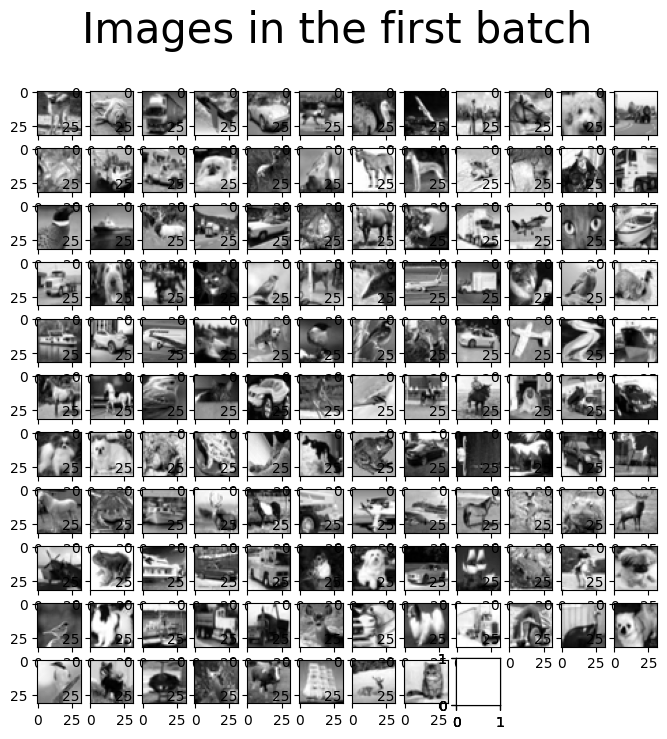

In [2]:
dataset = transform_data(CIFAR10, store_path="../../datasets")
train_dataloader = DataLoader(dataset, batch_size=128, num_workers=0, shuffle=True)
show_first_batch(train_dataloader)

# Linear scheduler

In [16]:
model = Unet(dim = 64).to(device)

diffusion = GaussianDiffusion(
    model,
    image_size = 32,
    timesteps = 1000,
    sampling_timesteps=250,
    loss_type = 'l2',  
    beta_schedule="linear",
).to(device)

diffusion.load_state_dict(torch.load(store_path, map_location=device))
diffusion.eval()
print('Model loaded')

Model loaded


In [5]:
trainer = Trainer(
    diffusion,
    train_dataloader,
    train_lr = 2e-4,
    train_num_steps = 40000, 
    device=device
) 

In [9]:
trainer.train()

100%|██████████| 40000/40000 [00:00<?, ?it/s]


In [17]:
generated_images = diffusion.sample(batch_size = 128, return_all_timesteps=True).cpu()

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

In [18]:
store_path = '../../model_weights/linear_cifar_steps_1000.pt'
torch.save(diffusion.state_dict(), store_path)

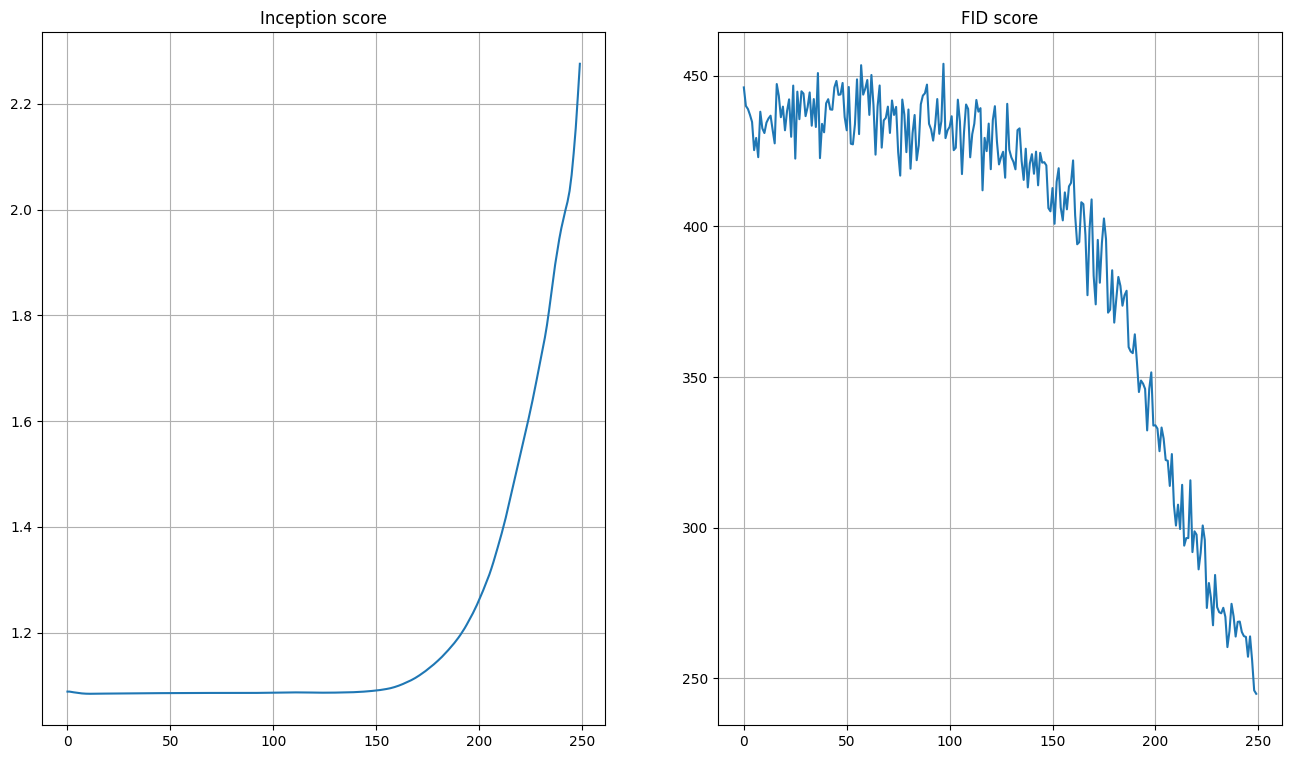

100%|██████████| 250/250 [40:40<00:00,  9.76s/it]


In [20]:
plot_metrics_iddpm(generated_images, dataset, device=torch.device('cpu'), n_timestamps=250, batch_size=128)

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

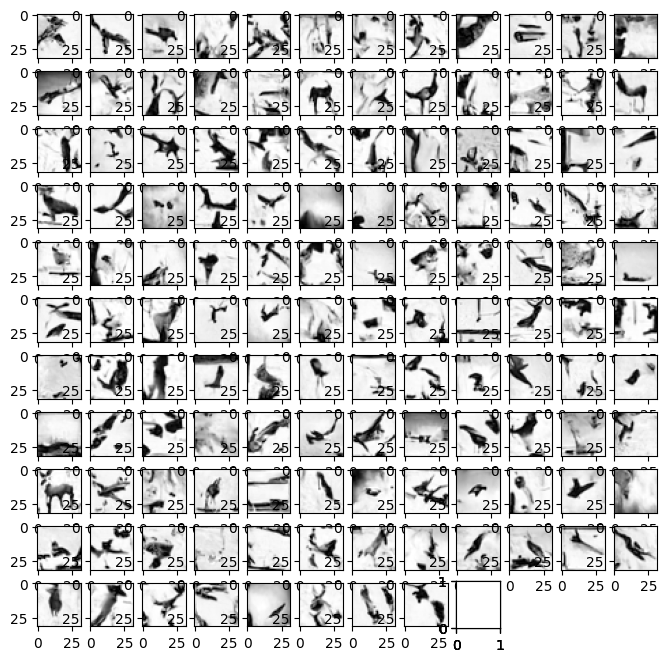

In [21]:
generated_images_for_show = diffusion.sample(batch_size = 128).cpu()
show_images(generated_images_for_show)

# Cosine scheduler

In [23]:
model = Unet(dim = 64).to(device)

diffusion = GaussianDiffusion(
    model,
    image_size = 32,
    timesteps = 1000,
    sampling_timesteps=250,
    loss_type = 'l2',  
    beta_schedule="cosine",
).to(device)

In [24]:
trainer = Trainer(
    diffusion,
    train_dataloader,
    train_lr = 2e-4,
    train_num_steps = 40000, 
    device=device
) 

In [26]:
trainer.train()

loss: 0.0720: 100%|██████████| 40000/40000 [1:23:34<00:00,  5.37it/s]


In [ ]:
generated_images = diffusion.sample(batch_size = 128, return_all_timesteps=True).cpu()

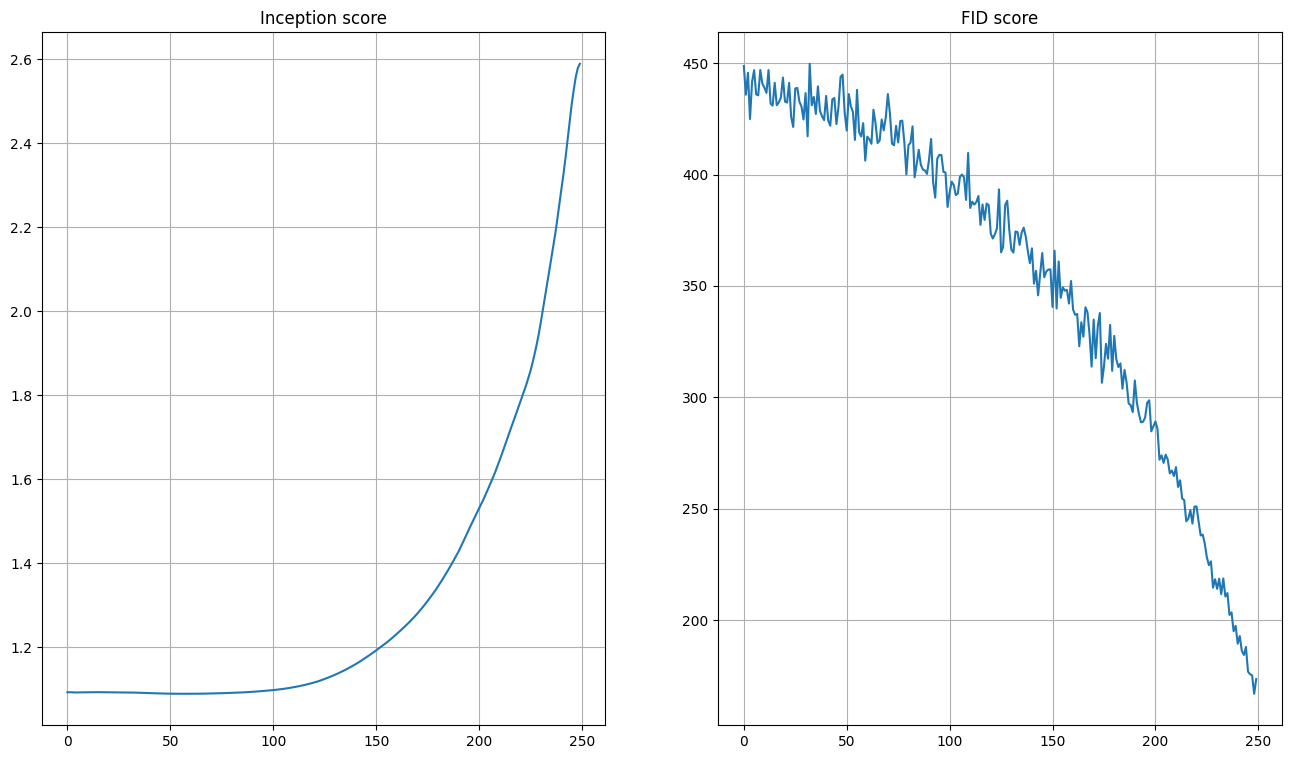

100%|██████████| 250/250 [42:08<00:00, 10.11s/it]


In [35]:
plot_metrics_iddpm(generated_images, dataset, device=torch.device('cpu'), n_timestamps=250, batch_size=128)

In [36]:
store_path = '../../model_weights/ev_cifar_cosine_steps_1000.pt'
torch.save(diffusion.state_dict(), store_path)

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

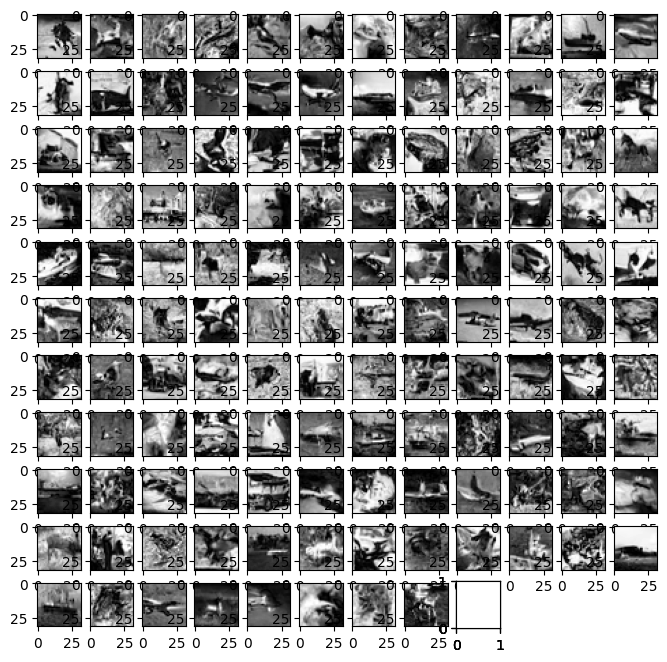

In [37]:
generated_images_for_show = diffusion.sample(batch_size = 128).cpu()
show_images(generated_images_for_show)

# Betas plots

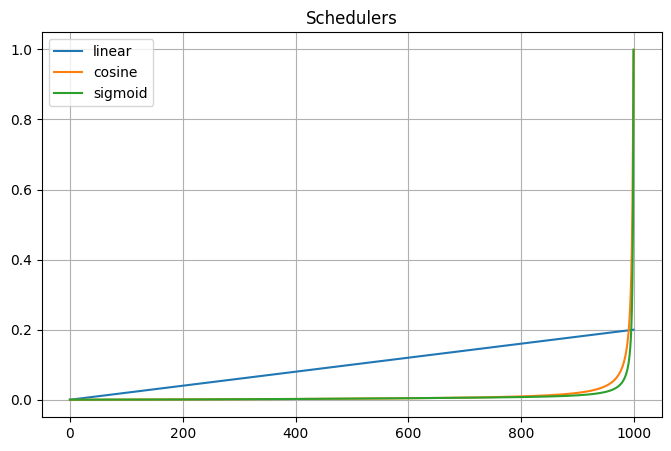

In [54]:
from diffusion_models.iddpm import linear_beta_schedule, cosine_beta_schedule, sigmoid_beta_schedule
from IPython.display import clear_output
import matplotlib.pyplot as plt


clear_output(True)
plt.figure(figsize=(8, 5))

plt.plot(linear_beta_schedule(1000))
plt.plot(cosine_beta_schedule(1000, 0.00001))
plt.plot(sigmoid_beta_schedule(1000))
plt.title('Schedulers')
plt.legend(['linear', 'cosine', 'sigmoid'])
plt.grid()
plt.show()